# Model Pipeline Version 5
- load full census data
- Use Rolling Method
- Feature engineering
- Result Analysis

In [ ]:
pip install us

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.1 MB/s eta 0:00:00
  Created wheel for us: filename=us-3.1.1-py3-none-any.whl size=12550 sha256=e76958de9a3fe37f08b290be2f6c22eaa99e7c689cdb3bc795f079d06555f32a
  Stored in directory: /root/.cache/pip/wheels/da/f9/64/9669135a7ce533faf78e3b32259c505f964f03b069be6844f8
Successfully built us


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import calendar
from us import states

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# connect to google drive
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import files

## Match to Old Census tract codes

In [ ]:
# merge all counties id into one

worksheet1 = gc.open('cobb_county_new_tract').sheet1

worksheet2 = gc.open('DeKalb_county_new_tract').sheet1

worksheet3 = gc.open('fulton_county_new_tract').sheet1

worksheet4 = gc.open('gwinnet_county_new_tract').sheet1

worksheet5 = gc.open('clayton_county_new_tract').sheet1

# get_all_values gives a list of rows.
rows1 = worksheet1.get_all_values()
rows2 = worksheet2.get_all_values()
rows3 = worksheet3.get_all_values()
rows4 = worksheet4.get_all_values()
rows5 = worksheet5.get_all_values()

all_rows = rows1 + rows2 + rows3 + rows4 + rows5

# Convert to a DataFrame and render.
tract_id_difference = pd.DataFrame.from_records(all_rows)
tract_id_difference.columns = tract_id_difference.iloc[0]
tract_id_difference = tract_id_difference[1:].reset_index(drop=True)

## Fecth eviction data

In [ ]:
# create a function to fill the missing month in eviction dataset

def fill_missing_months(df, date_column, tract_column):
    # Drop rows with date not in format month/day/year
    df[date_column] = pd.to_datetime(
        df[date_column], format='%m/%d/%Y', errors='coerce')
    df = df.dropna(subset=[date_column])
    df = df[[date_column, tract_column]]

    # Get the unique tracts in the DataFrame
    tracts = df[tract_column].unique()

    filled_dfs = []  # List to store filled DataFrames for each tract

    # Fill missing months for each tract individually
    for tract in tracts:
        # Filter DataFrame for the current tract
        tract_df = df[df[tract_column] == tract]

        # Check if tract_df contains valid rows
        if not tract_df.empty:
            # Get the year from the minimum and maximum dates for the tract
            min_date = tract_df[date_column].dt.date.min()
            max_date = tract_df[date_column].dt.date.max()

            # Create a DataFrame with all months in the year for the tract
            year_range = pd.date_range(start=min_date, end=max_date, freq='MS')
            all_months_df = pd.DataFrame({date_column: year_range})

            # Merge the original tract_df with the all_months_df to fill missing months
            filled_tract_df = pd.merge(
                all_months_df, tract_df, on=date_column, how='left')
            # Insert the tract ID in the filled rows
            filled_tract_df[tract_column] = filled_tract_df[tract_column].fillna(
                tract)

            filled_dfs.append(filled_tract_df)

    # Combine the filled DataFrames for all tracts
    filled_df = pd.concat(filled_dfs)
    filled_df.reset_index(drop=True, inplace=True)

    return filled_df

def get_eviction_data(url: str) -> pd.DataFrame:
  r = requests.get(url)
  json = r.json()

  df = pd.DataFrame(json[0])
  df = df.reset_index()
  df = df.rename(columns={'index': 'date'})

  for i in range(1, len(json)):
    df1 = pd.DataFrame(json[i])
    df1 = df1.reset_index()
    df1 = df1.rename(columns={'index': 'date'})
    df = pd.concat([df, df1], axis=0)

  df.reset_index(drop=True, inplace=True)
  # drop NA values
  df.dropna(axis=0, subset=['TractID'], inplace=True)
  df.drop(df[df['TractID'] == '99999999999'].index, inplace = True)

  # extract last 6 digits from Tract ID for matching Tract ID with census Tract ID
  df['Eviction_Tract'] = df['TractID'].astype(str).str[-6:]
  df['Eviction_Tract'] = df['Eviction_Tract'].str[:-2] + '.' + df['Eviction_Tract'].str[-2:]

  # remove the 0s in front
  df['Eviction_Tract'] = df['Eviction_Tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['Eviction_Tract'].str.endswith('00')
  df.loc[condition, 'Eviction_Tract'] = df.loc[condition, 'Eviction_Tract'].str[:-3]

  #data clean = drop unnecessary columns
  columns_to_drop = ["TractID", "_id", "updatedOn"]
  df = df.drop(columns = columns_to_drop)
  df.drop_duplicates(subset = ['date', 'Eviction_Tract'], inplace = True)
  df.reset_index(drop=True, inplace=True)

  filled_df = fill_missing_months(df, 'date', 'Eviction_Tract')
  df = filled_df.merge(df, on=['date', 'Eviction_Tract'], how='left')
  df['CountyID'] = df['CountyID'].fillna(method='ffill')

  return df

# create a function to subset the data by year
def subset_by_year(df, year):
  df = df[df['date'].dt.year == year]
  return df

In [ ]:
eviction_url = 'https://atl-eviction-tracker.herokuapp.com/rest/tractbymonth'
df_eviction = get_eviction_data(eviction_url)

df_2020 = subset_by_year(df_eviction, 2020)
df_2021 = subset_by_year(df_eviction, 2021)
df_2022 = subset_by_year(df_eviction, 2022)
df_2023 = subset_by_year(df_eviction, 2023)

## Get Yearly Census Data


In [ ]:
api_key = "e4f8c3090a4c3bd7eb07351bedbe1a3dc039f53d"  # put census api key here

# Get the state code
state_names = ['GA']  # put the state name here

state_codes_list = []
for i in state_names:
    exec('state_code = states.{}.fips'.format(i))
    state_codes_list.append(state_code)

state_codes_list_str = ','.join(state_codes_list)

# Get the counties
county_list = list(df_eviction.CountyID.unique())
try:
    county_list.remove(None)
except:
    county_list

county_list_str = ','.join(county_list)

In [ ]:
def get_census_api_url(variables: list, year: str) -> str:
    ''' get the api url for the variables we want'''
    variables_str = ','.join(variables)
    get_url = 'https://api.census.gov/data/{}/acs/acs5/profile?get=NAME,{}&for=tract:*&in=state:{}&in=county:{}&key={}'.format(
        year, variables_str, state_codes_list_str, county_list_str, api_key)
    return(get_url)


def get_census_api_data(url: str) -> pd.DataFrame:
    '''get the census data from api url'''
    r = requests.get(url)
    json = r.json()
    dff = pd.DataFrame(json)

    # format the data frame
    dff.columns = dff.iloc[0]
    dff = dff[1:]
    dff.reset_index(drop=True, inplace=True)
    return(dff)

def match_census_data(df: pd.DataFrame, tract_match: pd.DataFrame, feature_list: list) -> pd.DataFrame:
  # match the tract code to the old tract code and add-up

  # extract last 5 digits from ACS data and replace old 'tract' column
  df['tract'] = df['tract'].astype(str).str[-6:]
  df['tract'] = df['tract'].str[:-2] + '.' + df['tract'].str[-2:]

  # remove the 0s in front
  df['tract'] = df['tract'].str.lstrip('0')
  # remove the 0s by end of integer tract id
  condition = df['tract'].str.endswith('00')
  df.loc[condition, 'tract'] = df.loc[condition, 'tract'].str[:-3]

  df = df.merge(tract_match, left_on='tract', right_on='Census_Tract')
  df = df.drop(columns = ['Census_Tract'])

  df[feature_list] = df[feature_list].astype(float)
  df = df.groupby(['Eviction_Tract', 'state', 'county'])[feature_list].sum().reset_index()

  return df

def get_yearly_census_data(year: str, df_tract_match: pd.DataFrame) -> pd.DataFrame:
    # Define the lists of variables for each category

    race_list = ['DP05_0037E', 'DP05_0038E', 'DP05_0039E',
                 'DP05_0044E', 'DP05_0052E', 'DP05_0057E']
    edu_list = ['DP02_0060E', 'DP02_0061E', 'DP02_0062E', 'DP02_0063E', 'DP02_0064E',
                'DP02_0065E', 'DP02_0066E']
    income_list = ['DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E',
                   'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP03_0060E', 'DP03_0061E']
    occ_list = ['DP03_0027E', 'DP03_0028E',
                'DP03_0029E', 'DP03_0030E', 'DP03_0031E']
    ind_list = ['DP03_0032E', 'DP03_0033E', 'DP03_0034E', 'DP03_0035E', 'DP03_0036E',
                'DP03_0037E', 'DP03_0038E', 'DP03_0039E', 'DP03_0040E', 'DP03_0041E',
                'DP03_0042E', 'DP03_0043E', 'DP03_0044E', 'DP03_0045E']
    worker_list = ['DP03_0047E', 'DP03_0048E', 'DP03_0049E', 'DP03_0050E']
    emp_list = ['DP03_0002E', 'DP03_0003E', 'DP03_0004E', 'DP03_0005E', 'DP03_0006E', 'DP03_0007E']
    house_list = ['DP04_0046E', 'DP04_0047E', 'DP04_0005E', 'DP04_0049E']
    sex_list = ['DP05_0002E', 'DP05_0003E']
    rent_list = ['DP04_0127E',	'DP04_0128E',	'DP04_0129E',	'DP04_0130E',	'DP04_0131E',	'DP04_0132E',	'DP04_0133E',	'DP04_0135E']
    rent_over_income_list = ['DP04_0137E',	'DP04_0138E',	'DP04_0139E',	'DP04_0140E',	'DP04_0141E',	'DP04_0142E',	'DP04_0143E']


    # Generate the URLs for each category
    url_race = get_census_api_url(race_list, year)
    url_edu = get_census_api_url(edu_list, year)
    url_income = get_census_api_url(income_list, year)
    url_occ = get_census_api_url(occ_list, year)
    url_ind = get_census_api_url(ind_list, year)
    url_worker = get_census_api_url(worker_list, year)
    url_emp = get_census_api_url(emp_list, year)
    url_house = get_census_api_url(house_list, year)
    url_sex = get_census_api_url(sex_list, year)
    url_rent = get_census_api_url(rent_list, year)
    url_rent_over_income = get_census_api_url(rent_over_income_list, year)

    # Fetch the data for each category
    df_race = get_census_api_data(url_race)
    df_edu = get_census_api_data(url_edu)
    df_income = get_census_api_data(url_income)
    df_occ = get_census_api_data(url_occ)
    df_ind = get_census_api_data(url_ind)
    df_worker = get_census_api_data(url_worker)
    df_emp = get_census_api_data(url_emp)
    df_house = get_census_api_data(url_house)
    df_sex = get_census_api_data(url_sex)
    df_rent = get_census_api_data(url_rent)
    df_rent_over_income = get_census_api_data(url_rent_over_income)

    # match the tract code to the old tract code and add-up
    df_race = match_census_data(df_race, df_tract_match, race_list)
    df_edu = match_census_data(df_edu, df_tract_match, edu_list)
    df_income = match_census_data(df_income, df_tract_match, income_list)
    df_occ = match_census_data(df_occ, df_tract_match, occ_list)
    df_ind = match_census_data(df_ind, df_tract_match, ind_list)
    df_worker = match_census_data(df_worker, df_tract_match, worker_list)
    df_emp = match_census_data(df_emp, df_tract_match, emp_list)
    df_house = match_census_data(df_house, df_tract_match, house_list)
    df_sex = match_census_data(df_sex, df_tract_match, sex_list)
    df_rent = match_census_data(df_rent, df_tract_match, rent_list)
    df_rent_over_income = match_census_data(df_rent_over_income, df_tract_match, rent_over_income_list)

    # Merge the data frames
    df_census = df_race.merge(
        df_edu, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_income, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_occ, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_ind, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_worker, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_emp, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_house, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_sex, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent, on=['Eviction_Tract', 'state', 'county'], how='left')
    df_census = df_census.merge(
        df_rent_over_income, on=['Eviction_Tract', 'state', 'county'], how='left')

    return df_census

In [ ]:
ACS_2020 = get_yearly_census_data('2020', tract_id_difference)
ACS_2021 = get_yearly_census_data('2021', tract_id_difference)

## Merge Eviction and Census data


In [ ]:
# No ACS data for 2022 and after
def merge_census_and_eviction(census_df, eviction_df):
    eviction_df_copy = eviction_df.copy()

    # Rename the CountyID column as county
    eviction_df_copy = eviction_df_copy.drop(columns = ['CountyID'], axis = 1)

    # drop tracts that are in several counties
    tmp = census_df.groupby(['Eviction_Tract'])['county'].count().reset_index()
    l = tmp.loc[tmp.county > 1, 'Eviction_Tract'].tolist()
    census_df_copy = census_df.loc[census_df['Eviction_Tract'].isin(l) == 0]

    # Merge the evicted data and census data
    merged_df = eviction_df_copy.merge(
        census_df_copy, on=['Eviction_Tract'], how='left')

    return merged_df

# Create Year, Month and Day column
def date_preprocess(all_data):
    all_data['date'] = pd.to_datetime(all_data['date'])
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['day'] = all_data['date'].dt.day
    return all_data

In [ ]:
# Concat the merged data frames
merged_2020 = merge_census_and_eviction(ACS_2020, df_2020)
merged_2021 = merge_census_and_eviction(ACS_2021, df_2021)
merged_2022 = merge_census_and_eviction(ACS_2021, df_2022)
merged_2023 = merge_census_and_eviction(ACS_2021, df_2023)

data = pd.concat([merged_2020, merged_2021, merged_2022, merged_2023], ignore_index=True)
data = date_preprocess(data)

In [ ]:
from google.colab import files

data.to_csv('final_data.csv', index=False)
files.download('final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model


In [ ]:
def get_new_features(data: pd.DataFrame, lag: int, cutoff: str) -> pd.DataFrame:

    df = data.copy()
    df = df.rename(columns = {'Eviction_Tract': 'tract'})

    # drop all rows with missing values except FilingsByMonth
    sub = df.columns.to_list()
    sub.remove('FilingsByMonth')
    df = df.dropna(subset=sub, how='any')
    df.reset_index(drop=True, inplace=True)

    # sort the dataframe by tract and date
    df = df.sort_values(['state', 'county', 'tract', 'date'], ascending=True)
    df.reset_index(drop=True, inplace=True)

    # add lag terms into the dataframe
    for i in range(1, lag + 1):
      df[f'FilingsByMonth_lag{i}'] = df.groupby(['state', 'county', 'tract'])['FilingsByMonth'].shift(i)

    # drop all rows with FilingsByMonth missing
    df = df.dropna(subset=['FilingsByMonth'], how='any')
    df.reset_index(drop=True, inplace=True)

    # Binning based on FilingsByMonth
    # Only use the average data before cutoff in case of data leekage
    tmp = df.query('date < @cutoff').groupby('tract').agg(FilingsByMonth_mean = ('FilingsByMonth', 'mean')).reset_index()

    # eviction: super low low mid high (use eviction before cutoff)
    tmp['super_low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean <= 5').index, 'super_low_eviction'] = 1

    tmp['low_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 5 and FilingsByMonth_mean <= 20').index, 'low_eviction'] = 1

    tmp['mid_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 20 and FilingsByMonth_mean <= 60').index, 'mid_eviction'] = 1

    tmp['high_eviction'] = 0
    tmp.loc[tmp.query('FilingsByMonth_mean > 60').index, 'high_eviction'] = 1

    tmp = tmp.drop(columns = ['FilingsByMonth_mean'], axis = 1)

    df = df.merge(tmp, on = ['tract'], how = 'left')

    # CARES Act Moratorium: April 2020- July 2020
    df['CARES'] = 0
    df.loc[df.query('date >= "2020-04-01" and date <= "2020-07-01"').index, 'CARES'] = 1

    # CDC Moratorium: September 2021 - September 2022
    df['CDC'] = 0
    df.loc[df.query('date >= "2021-09-01" and date <= "2022-09-01"').index, 'CDC'] = 1

    # processing categorical variables

    # for features with a few categories, use onehot encoding
    le = LabelEncoder()
    df['tract_encoded'] = le.fit_transform(df['tract'])

    # for features with a lot of categories, use label encoding
    df = pd.get_dummies(df, columns=['state', 'county'])

    return df

def prepare_data(target_column: str, feature_list: list, df: pd.DataFrame):
  X = df[feature_list]
  y = df[target_column]
  return X, y


### Rolling Model

In [ ]:
def rolling_prediction(cutoff: str, lag: int, rolling_number: int, df: pd.DataFrame, model = False):

  # use the cutoff to separate the training set and the testing set
  cutoff_date = pd.to_datetime(cutoff)

  # set the target column
  target = 'FilingsByMonth'

  # get the feature names
  features = df.columns.to_list()
  features.remove(target)
  features.remove('date')

  cat_list = df.select_dtypes(include=['object']).columns
  for i in cat_list:
    features.remove(i)

  # get testing set for first month
  df_testing = df.query('date == @cutoff_date').reset_index(drop=True)
  X_test, y_test = prepare_data(target, features, df_testing)

  if model == False:
    # get training set
    df_training = df.query('date < @cutoff_date').reset_index(drop=True)

    '''
    # upsampling for not low eviction number
    df1 = df_training.loc[df_training[target] <= 5]
    df2 = df_training.loc[(df_training[target] > 5) & (df_training[target] <= 40)]
    df3 = df_training.loc[df_training[target] > 40]

    df3 = df3.sample(len(df2), replace=True)
    df_training = pd.concat([df1, df2, df3])
    '''

    X_train, y_train = prepare_data(target, features, df_training)

    # Build model
    model = xgb.XGBRegressor(
      booster='gbtree', objective='reg:squarederror', n_estimators=100, learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.7)
    # Train model
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=False)  # Change verbose to True if you want to see it train

  df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
  df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
  df_result = df_testing[['date', 'FilingsByMonth', 'tract', 'FilingsByMonth_prediction']]

  if rolling_number == 1:
    return df_result, model

  else:
    for i in range(1, rolling_number):
      cutoff_new = cutoff_date + pd.DateOffset(months=i)

      # use the prediction to replace the lag term
      for j in range(lag, 1, -1):
        df_testing[f'FilingsByMonth_lag{j}'] = df_testing[f'FilingsByMonth_lag{j-1}']

      df = df.drop(columns = ['FilingsByMonth_lag1'], axis = 1)
      df = df.merge(df_result[['tract', 'FilingsByMonth_prediction']], on = ['tract'], how = 'left')
      df = df.rename(columns = {'FilingsByMonth_prediction': 'FilingsByMonth_lag1'})

      df_testing = df.query('date == @cutoff_new').reset_index(drop=True)
      X_test, y_test = prepare_data(target, features, df_testing)
      df_testing['FilingsByMonth_prediction'] = model.predict(X_test)
      df_testing['FilingsByMonth_prediction'] = df_testing['FilingsByMonth_prediction'].round().astype(int)
      df_result = df_testing[['date', 'FilingsByMonth', 'tract', 'FilingsByMonth_prediction']]

    return df_result

### Error Metrics






In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    # MAPE calculation
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def model_evaluation(df_result: pd.DataFrame):
    # r2_score
    r2 = r2_score(y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # mse
    mse = mean_squared_error(
        y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # rmse
    rmse = np.sqrt(mse)

    # mae
    mae = mean_absolute_error(
        y_true = df_result['FilingsByMonth'], y_pred = df_result['FilingsByMonth_prediction'])

    # mape
    mape = mean_absolute_percentage_error(
        df_result['FilingsByMonth'], df_result['FilingsByMonth_prediction'])

    print(f"R2_Score: {r2}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-06-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-06-01) results:
R2_Score: 0.7772575596318224
MSE: 95.23655913978494
RMSE: 9.758922027549199
MAE: 6.136200716845878
MAPE: 52.18584620498422

3 month results
R2_Score: 0.7200117486772664
MSE: 177.0125
RMSE: 13.304604466123749
MAE: 7.723214285714286
MAPE: 44.501278860638585

6 month results
R2_Score: 0.6800794559545378
MSE: 129.8980322003578
RMSE: 11.397281789986495
MAE: 6.649373881932021
MAPE: 69.94380211489874


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-07-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-07-01) results:
R2_Score: 0.8014314341364561
MSE: 94.39718804920913
RMSE: 9.715821532387734
MAE: 6.1124780316344465
MAPE: 50.09741038579024

3 month results
R2_Score: 0.7267466032899041
MSE: 149.12367491166077
RMSE: 12.211620486719228
MAE: 7.240282685512367
MAPE: 51.287829881592536

6 month results
R2_Score: 0.7909471930104124
MSE: 94.97330960854093
RMSE: 9.745425060434302
MAE: 6.165480427046264
MAPE: 55.457122567716766


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-08-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-08-01) results:
R2_Score: 0.7473109350647714
MSE: 159.75357142857143
RMSE: 12.639365942505638
MAE: 7.203571428571428
MAPE: 44.21818920972651

3 month results
R2_Score: 0.7636810884321193
MSE: 133.7609841827768
RMSE: 11.565508384103866
MAE: 6.899824253075571
MAPE: 46.04507382663008

6 month results
R2_Score: 0.7610396963099657
MSE: 158.748623853211
RMSE: 12.599548557516297
MAE: 7.475229357798165
MAPE: 57.540907454757594


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-09-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-09-01) results:
R2_Score: 0.7501889501641968
MSE: 136.3303886925795
RMSE: 11.676060495414518
MAE: 6.810954063604241
MAPE: 52.18423313255553

3 month results
R2_Score: 0.6648529069864313
MSE: 136.0805008944544
RMSE: 11.66535472647336
MAE: 6.903398926654741
MAPE: 75.35827148080672

6 month results
R2_Score: 0.7875460990786216
MSE: 108.57042253521126
RMSE: 10.41971316952685
MAE: 6.517605633802817
MAPE: 51.794784473475005


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-10-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-10-01) results:
R2_Score: 0.7689005351585102
MSE: 130.8066783831283
RMSE: 11.437074730154048
MAE: 6.5676625659050965
MAPE: 46.90470990554694

3 month results
R2_Score: 0.7911861105041147
MSE: 94.86476868327402
RMSE: 9.739854654114405
MAE: 6.181494661921708
MAPE: 59.46289988753415

6 month results
R2_Score: 0.6552375868954287
MSE: 152.76344086021504
RMSE: 12.359750841348504
MAE: 7.731182795698925
MAPE: 79.73623658943156


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-11-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-11-01) results:
R2_Score: 0.710669134625129
MSE: 117.47763864042933
RMSE: 10.838710192658041
MAE: 6.161001788908766
MAPE: 65.23318647515339

3 month results
R2_Score: 0.6787936905853553
MSE: 213.38715596330275
RMSE: 14.607777242390533
MAE: 8.48440366972477
MAPE: 53.88304639359435

6 month results
R2_Score: 0.8080535798992923
MSE: 79.70017953321364
RMSE: 8.92749570334333
MAE: 5.73608617594255
MAPE: 50.63466604649486


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2022-12-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2022-12-01) results:
R2_Score: 0.8175884518983407
MSE: 82.87010676156584
RMSE: 9.103301970250456
MAE: 5.717081850533808
MAPE: 53.734409808874496

3 month results
R2_Score: 0.7908775338939387
MSE: 106.86795774647888
RMSE: 10.3376959592783
MAE: 6.498239436619718
MAPE: 52.435884134811296

6 month results
R2_Score: 0.7226798023180301
MSE: 117.29729729729729
RMSE: 10.83038767991697
MAE: 6.648648648648648
MAPE: 73.39836769452575


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-01-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)
df_result_6m = rolling_prediction(predict_month, 13, 6, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

# 6 month
print('\n6 month results')
model_evaluation(df_result_6m)

1 month (2023-01-01) results:
R2_Score: 0.7781445896356596
MSE: 147.38532110091742
RMSE: 12.14023562789938
MAE: 7.201834862385321
MAPE: 54.10312056322063

3 month results
R2_Score: 0.7084350719329034
MSE: 129.19175627240142
RMSE: 11.366255156048602
MAE: 7.184587813620071
MAPE: 74.18751877951073

6 month results
R2_Score: 0.7419590125515438
MSE: 104.70318021201413
RMSE: 10.23245719326566
MAE: 6.3992932862190814
MAPE: 64.2891237288623


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-02-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-02-01) results:
R2_Score: 0.8047613832276799
MSE: 99.77288732394366
RMSE: 9.988637911344252
MAE: 6.304577464788732
MAPE: 52.72519493840315

3 month results
R2_Score: 0.7990946678535042
MSE: 83.42010771992818
RMSE: 9.133460884020263
MAE: 5.944344703770198
MAPE: 57.701830085188796


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-03-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-03-01) results:
R2_Score: 0.7043218017828912
MSE: 131.01433691756273
RMSE: 11.446149436276059
MAE: 6.849462365591398
MAPE: 67.28240595693056

3 month results
R2_Score: 0.7337427908492141
MSE: 112.61801801801802
RMSE: 10.612163682210053
MAE: 6.553153153153153
MAPE: 67.94136249842975


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-04-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)
df_result_3m = rolling_prediction(predict_month, 13, 3, df, model = model_1m)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

# 3 month
print('\n3 month results')
model_evaluation(df_result_3m)

1 month (2023-04-01) results:
R2_Score: 0.8254828146756298
MSE: 72.46319569120287
RMSE: 8.512531685180553
MAE: 5.515260323159785
MAPE: 53.053129925401365

3 month results
R2_Score: 0.7491217378114525
MSE: 101.79681978798587
RMSE: 10.089441004732912
MAE: 6.326855123674911
MAPE: 63.146065173472955


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-05-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

1 month (2023-05-01) results:
R2_Score: 0.7501732670774685
MSE: 105.66846846846848
RMSE: 10.279516937505793
MAE: 6.403603603603604
MAPE: 69.09493270089591


In [ ]:
# Set which month is the first month of the prediction
predict_month = '2023-06-01'

# get 13 months lag
df = get_new_features(data, 13, predict_month)

df_result_1m, model_1m = rolling_prediction(predict_month, 13, 1, df)

# 1 month
print(f'1 month ({predict_month}) results:')
model_evaluation(df_result_1m)

1 month (2023-06-01) results:
R2_Score: 0.7515296326860601
MSE: 100.81978798586573
RMSE: 10.040905735334125
MAE: 6.236749116607774
MAPE: 63.038755222118596


## Result Analysis

In [ ]:
def result_analysis(df_res: pd.DataFrame):
  df_res['error'] = df_res.FilingsByMonth_prediction - df_res.FilingsByMonth
  df_res['absolute_error'] = abs(df_res.FilingsByMonth_prediction - df_res.FilingsByMonth)

  fig = plt.figure(figsize = (15, 5))

  # Create histogram
  plt.subplot(1, 3, 1)
  sns.distplot(df_res.error, bins = 20)
  plt.legend(['Error'])
  x_major_locator = plt.MultipleLocator(10)
  ax1 = plt.gca()
  ax1.xaxis.set_major_locator(x_major_locator)

  plt.subplot(1, 3, 2)
  sns.distplot(df_res.absolute_error, bins = 20)
  plt.legend(['Absolute error'])
  x_major_locator = plt.MultipleLocator(10)
  ax2 = plt.gca()
  ax2.xaxis.set_major_locator(x_major_locator)

  # Create boxplot
  plt.subplot(1, 3, 3)
  plt.boxplot([df_res.error, df_res.absolute_error], labels = ['Error', 'Absolute error'])
  y_major_locator = plt.MultipleLocator(10)
  ax3 = plt.gca()
  ax3.yaxis.set_major_locator(y_major_locator)
  plt.show()

  print(df_res.error.describe())
  print('\n', df_res.absolute_error.describe())

  return df_res

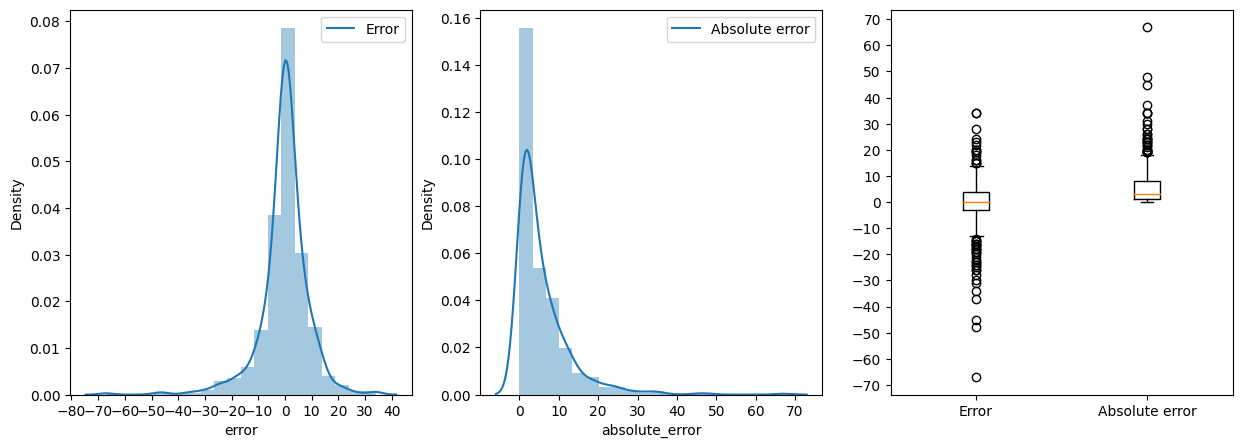

count    562.000000
mean      -0.225979
std        9.108604
min      -67.000000
25%       -3.000000
50%        0.000000
75%        4.000000
max       34.000000
Name: error, dtype: float64

 count    562.000000
mean       5.717082
std        7.090454
min        0.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       67.000000
Name: absolute_error, dtype: float64


,date,FilingsByMonth,tract,FilingsByMonth_prediction,error,absolute_error
63,2022-12-01,101.0,302.28,70,-31.0,31.0
126,2022-12-01,64.0,312.05,27,-37.0,37.0
225,2022-12-01,89.0,231.08,22,-67.0,67.0
267,2022-12-01,82.0,235.06,34,-48.0,48.0
314,2022-12-01,16.0,106.03,50,34.0,34.0
410,2022-12-01,65.0,73,31,-34.0,34.0
419,2022-12-01,30.0,77.06,64,34.0,34.0
510,2022-12-01,83.0,505.23,38,-45.0,45.0


In [ ]:
df_error = result_analysis(df_result_1m)
df_error[df_error.absolute_error > 30]

In [ ]:
def result_plot(df_res: pd.DataFrame):

  fig = plt.figure(figsize = (24, 8))

  # Create the scatter plot
  plt.subplot(1, 3, 1)
  plt.scatter(df_res.FilingsByMonth, df_res.FilingsByMonth_prediction)

  x = range(0, max(df_res.FilingsByMonth.astype(int)))
  plt.plot(x, x, color='red', label='Line')

  y_major_locator = plt.MultipleLocator(10)
  ax1 = plt.gca()
  ax1.yaxis.set_major_locator(y_major_locator)

  # Set labels for the axes
  plt.xlabel('Filings By Month')
  plt.ylabel('Prediction')

  # Create histogram
  plt.subplot(1, 3, 2)
  sns.distplot(df_res.FilingsByMonth, bins = 50)
  sns.distplot(df_res.FilingsByMonth_prediction, bins = 50)
  plt.legend(['Filings By Month', 'Prediction'])
  x_major_locator = plt.MultipleLocator(10)
  ax2 = plt.gca()
  ax2.xaxis.set_major_locator(x_major_locator)

  # Create boxplot
  plt.subplot(1, 3, 3)
  plt.boxplot([df_res.FilingsByMonth, df_res.FilingsByMonth_prediction], labels = ['Filings By Month', 'Prediction'])
  y_major_locator = plt.MultipleLocator(10)
  ax3 = plt.gca()
  ax3.yaxis.set_major_locator(y_major_locator)
  plt.show()

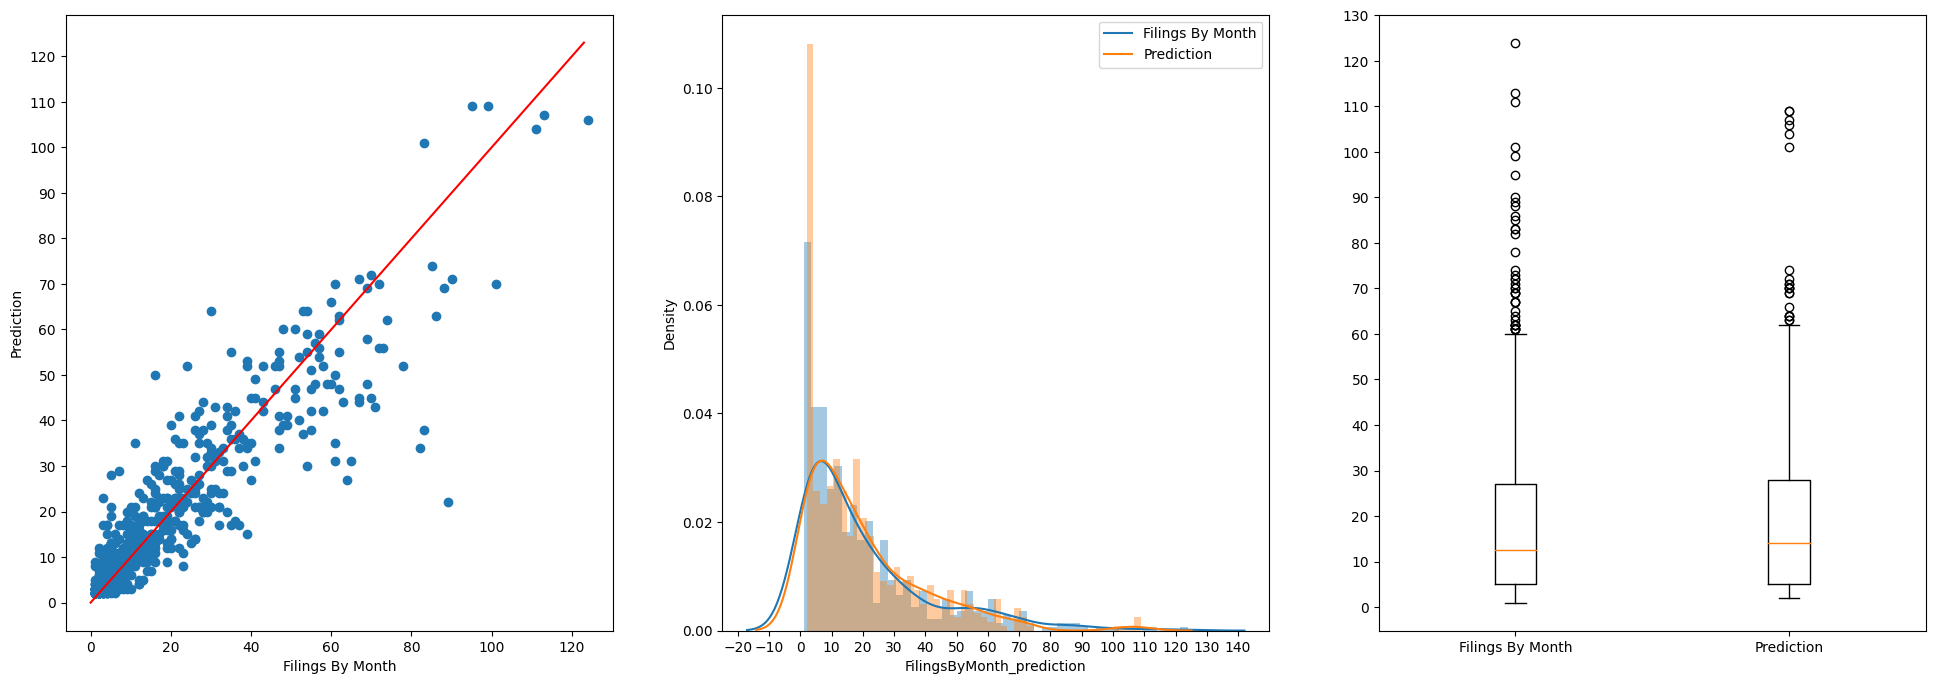

In [ ]:
result_plot(df_result_1m)

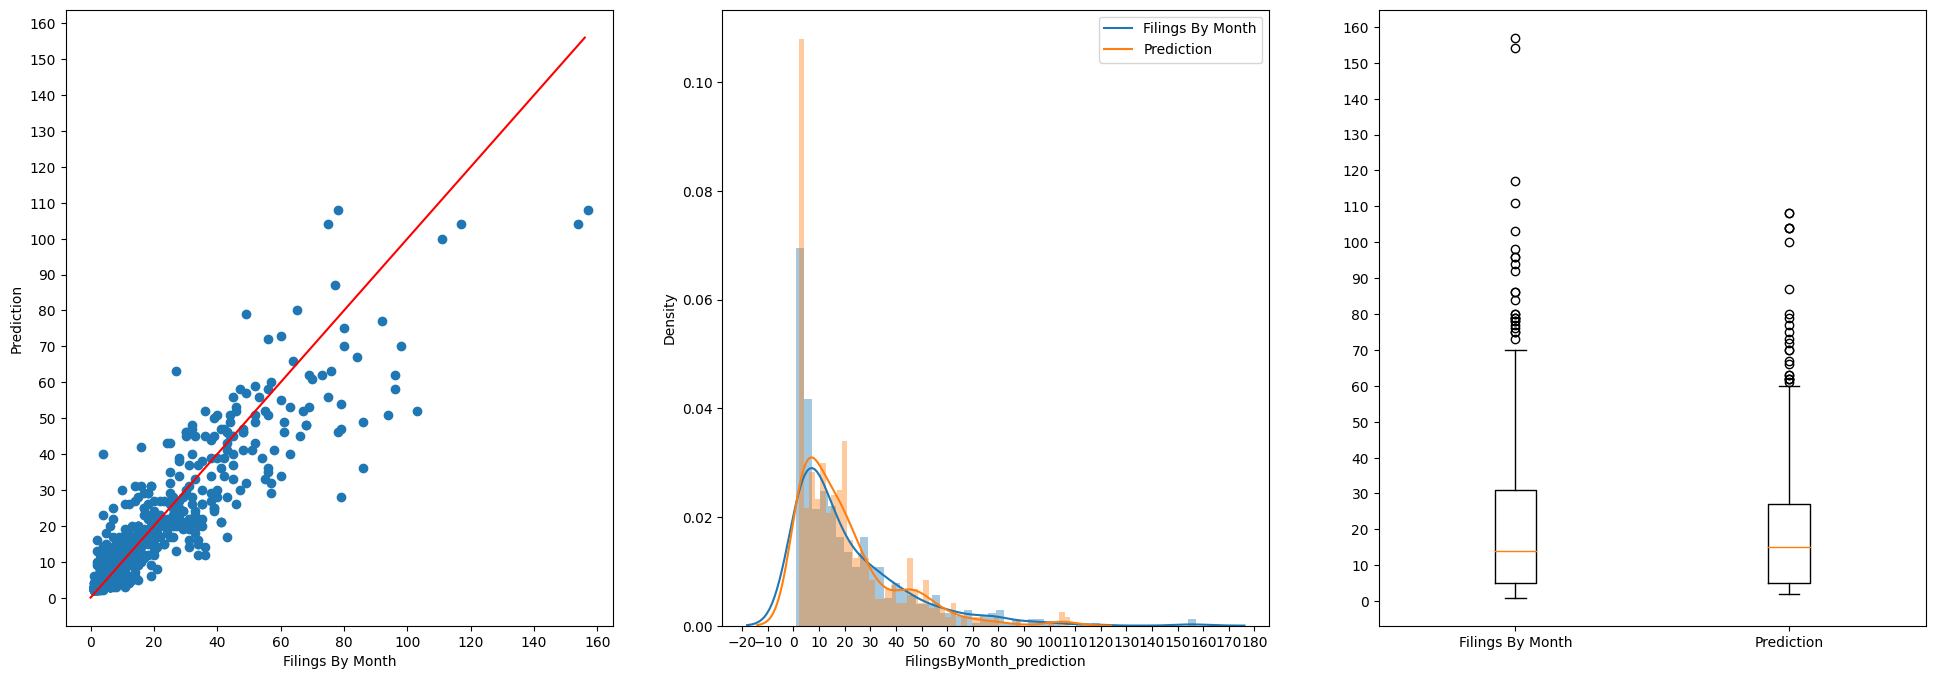

In [ ]:
result_plot(df_result_3m)

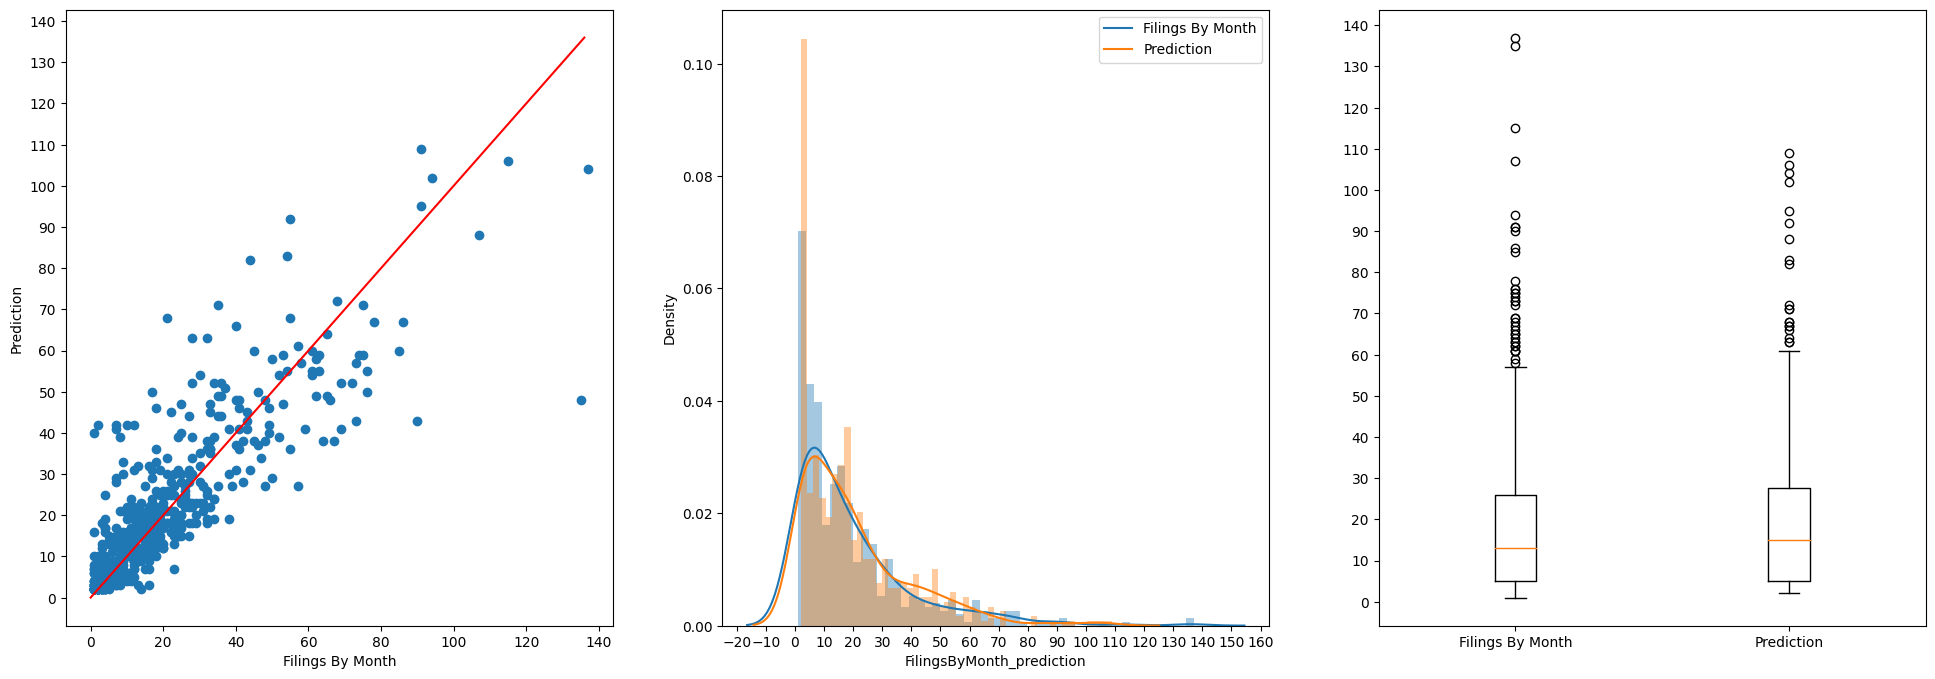

In [ ]:
result_plot(df_result_6m)

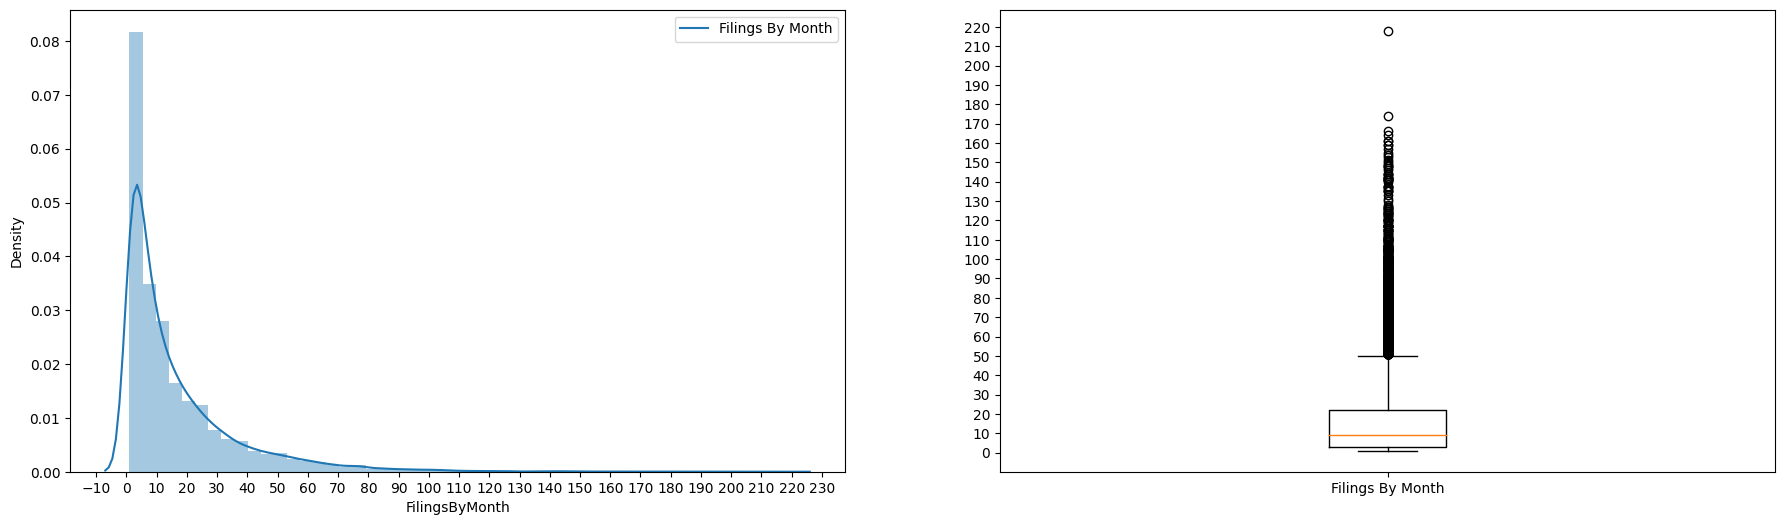

In [ ]:
fig = plt.figure(figsize = (22, 6))

# Create histogram
plt.subplot(1, 2, 1)
sns.distplot(df.FilingsByMonth, bins = 50)
plt.legend(['Filings By Month'])
x_major_locator = plt.MultipleLocator(10)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)

# Create boxplot
plt.subplot(1, 2, 2)
plt.boxplot([df.FilingsByMonth], labels = ['Filings By Month'])
y_major_locator = plt.MultipleLocator(10)
ax2 = plt.gca()
ax2.yaxis.set_major_locator(y_major_locator)
plt.show()

In [ ]:
df.FilingsByMonth.describe()

count    22194.000000
mean        16.585789
std         19.710390
min          1.000000
25%          3.000000
50%          9.000000
75%         22.000000
max        218.000000
Name: FilingsByMonth, dtype: float64

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

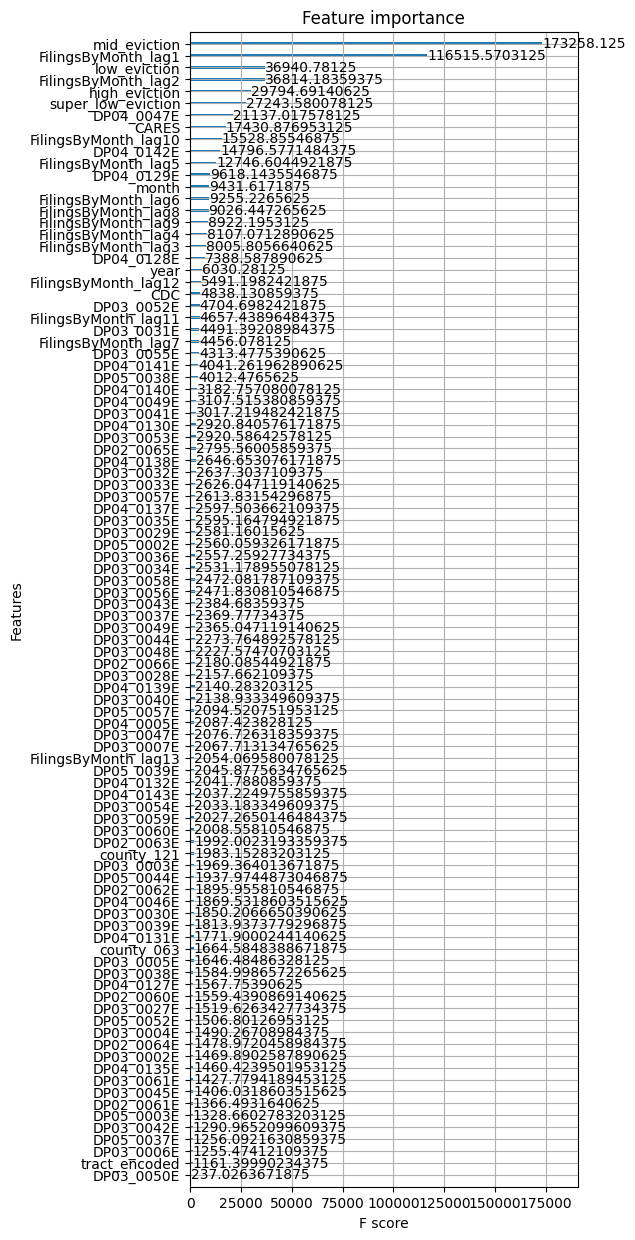

In [ ]:
plt.rcParams['figure.figsize'] = (5, 15)
xgb.plot_importance(model_1m, importance_type='gain')

In [ ]:
feature_importance = model_1m.get_booster().get_score(importance_type='gain')
feature_importance = pd.DataFrame({'feature': feature_importance.keys(
), 'importance': feature_importance.values()}).sort_values('importance', ascending=False)

feature_importance.reset_index(drop = True, inplace = True)
feature_importance

,feature,importance
0,mid_eviction,173258.125000
1,FilingsByMonth_lag1,116515.570312
2,low_eviction,36940.781250
3,FilingsByMonth_lag2,36814.183594
4,high_eviction,29794.691406
...,...,...
91,DP03_0042E,1290.965210
92,DP05_0037E,1256.092163
93,DP03_0006E,1255.474121
94,tract_encoded,1161.399902


In [ ]:
feature_importance.feature.tolist()

['mid_eviction',
 'FilingsByMonth_lag1',
 'low_eviction',
 'FilingsByMonth_lag2',
 'high_eviction',
 'super_low_eviction',
 'DP04_0047E',
 'CARES',
 'FilingsByMonth_lag10',
 'DP04_0142E',
 'FilingsByMonth_lag5',
 'DP04_0129E',
 'month',
 'FilingsByMonth_lag6',
 'FilingsByMonth_lag8',
 'FilingsByMonth_lag9',
 'FilingsByMonth_lag4',
 'FilingsByMonth_lag3',
 'DP04_0128E',
 'year',
 'FilingsByMonth_lag12',
 'CDC',
 'DP03_0052E',
 'FilingsByMonth_lag11',
 'DP03_0031E',
 'FilingsByMonth_lag7',
 'DP03_0055E',
 'DP04_0141E',
 'DP05_0038E',
 'DP04_0140E',
 'DP04_0049E',
 'DP03_0041E',
 'DP04_0130E',
 'DP03_0053E',
 'DP02_0065E',
 'DP04_0138E',
 'DP03_0032E',
 'DP03_0033E',
 'DP03_0057E',
 'DP04_0137E',
 'DP03_0035E',
 'DP03_0029E',
 'DP05_0002E',
 'DP03_0036E',
 'DP03_0034E',
 'DP03_0058E',
 'DP03_0056E',
 'DP03_0043E',
 'DP03_0037E',
 'DP03_0049E',
 'DP03_0044E',
 'DP03_0048E',
 'DP02_0066E',
 'DP03_0028E',
 'DP04_0139E',
 'DP03_0040E',
 'DP05_0057E',
 'DP04_0005E',
 'DP03_0047E',
 'DP03_0007E

### Tree Plot

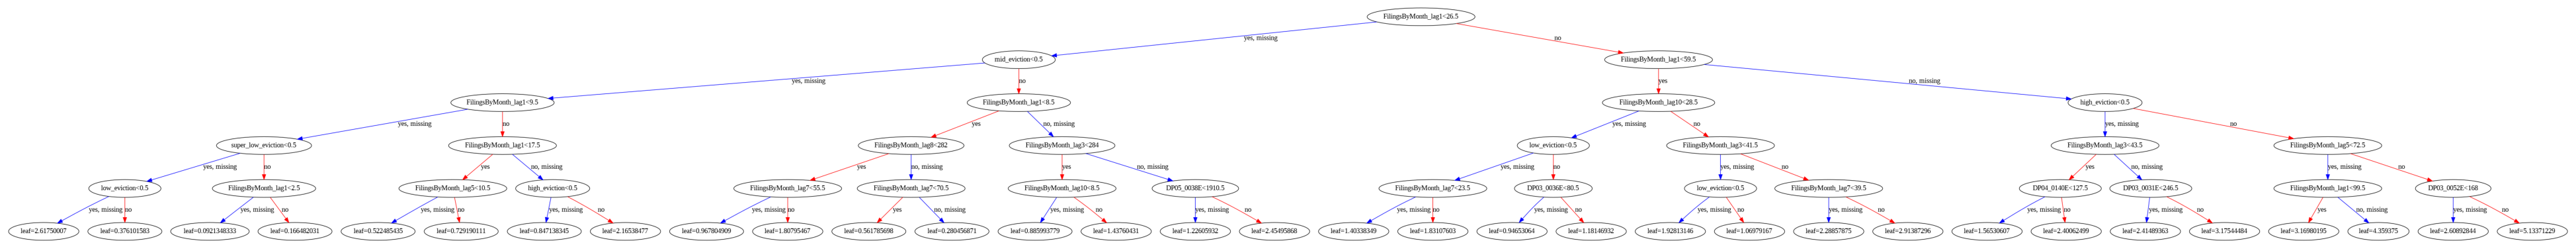

In [ ]:
plt.figure(figsize=(50, 50))
xgb.plot_tree(model_1m, num_trees=0, ax=plt.gca())
plt.show()